# Carving Unit Tests

So far, we have always generated _system input_, i.e. data that the program as a whole obtains via its input channels.  If we are interested in testing only a small set of functions, having to go through the system can be very inefficient.  This chapter introduces a technique known as _carving_, which, given a system test, automatically extracts a set of _unit tests_ that replicate the calls seen during the unit test.  The key idea is to _record_ such calls such that we can _replay_ them later – as a whole or selectively.

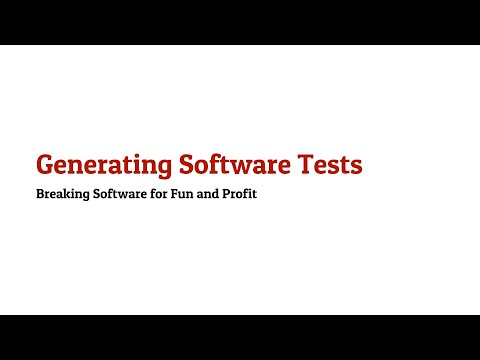

In [1]:
from fuzzingbook_utils import YouTubeVideo
YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* Carving makes use of dynamic traces of function calls and variables, as introduced in the [chapter on configuration fuzzing](ConfigurationFuzzer.ipynb).

## System Tests vs Unit Tests

Remember the URL grammar introduced for [grammar fuzzing](Grammars.ipynb)?  With such a grammar, we can happily test a Web browser again and again, checking how it reacts to arbitrary page requests.

Let us define a very simple "web browser" that goes and downloads the content given by the URL.

In [2]:
import urllib.parse, urllib.request

In [3]:
def webbrowser(url):
    """Download the http/https resource given by the URL"""
    response = urllib.request.urlopen(url)
    if response.getcode() == 200:
        contents = response.read()
    return contents

Let us apply this on [fuzzingboook.org](https://www.fuzzingbook.org/) and measure the time, using the [Timer class](Timer.ipynb):

In [4]:
from Timer import Timer

In [5]:
with Timer() as webbrowser_timer:
    fuzzingbook_contents = webbrowser("http://www.fuzzingbook.org/html/Fuzzer.html")

print("Downloaded %d bytes in %.2f seconds" % (len(fuzzingbook_contents), webbrowser_timer.elapsed_time()))

Downloaded 394166 bytes in 0.19 seconds


In [6]:
fuzzingbook_contents[:100]

b'\n<!-- A html document -->\n<!-- \nwith standard nbconvert css layout\nwith standard nbconvert input/out'

Having to start a whole browser (or having it render a Web page) again and again means lots of overhead, though – in particular if we want to test only a subset of its functionality.  In particular, after a change in the code, we would prefer to test only the subset of functions that is affected by the change, rather than running the well-tested functions again and again.

Let us assume we change the function that takes care of parsing the given URL and decomposing it into the individual elements – the scheme ("http"), the network location (`"www.fuzzingbook.com"`), or the path (`"/html/Fuzzer.html"`).  This function is named `urlparse()`:

In [7]:
from urllib.parse import urlparse

In [8]:
urlparse('https://www.fuzzingbook.com/html/APIFuzzer.html')

ParseResult(scheme='https', netloc='www.fuzzingbook.com', path='/html/APIFuzzer.html', params='', query='', fragment='')

You see how the individual elements of the URL – the _scheme_ (`"http"`), the _network location_ (`"www.fuzzingbook.com"`), or the path (`"//html/APIFuzzer.html"`) are all properly identified.  Other elements (like `params`, `query`, or `fragment`) are empty, because they were not part of our input.

The interesting thing is that executing only `urlparse()` is orders of magnitude faster than running all of `webbrowser()`.  Let us measure the factor:

In [9]:
runs = 1000
with Timer() as urlparse_timer:
    for i in range(runs):
        urlparse('https://www.fuzzingbook.com/html/APIFuzzer.html')

avg_urlparse_time = urlparse_timer.elapsed_time() / 1000
avg_urlparse_time

3.9056939999682074e-06

Compare this to the time required by the webbrowser

In [10]:
webbrowser_timer.elapsed_time()

0.19321028500007742

The difference in time is huge:

In [11]:
webbrowser_timer.elapsed_time() / avg_urlparse_time

49468.87416209518

Hence, in the time it takes to run `webbrowser()` once, we can have _hundreds of thousands_ of executions of `urlparse()` – and this does not even take into account the time it takes the browser to render the downloaded HTML, to run the included scripts, and whatever else happens when a Web page is loaded.  Hence, strategies that allow us to test at the _unit_ level are very promising as they can save lots of overhead.

## Carving Unit Tests

Testing methods and functions at the unit level requires a very good understanding of the individual units to be tested as well as their interplay with other units.  Setting up an appropriate infrastructure and writing unit tests by hand thus is demanding, yet rewarding.  There is, however, an interesting alternative to writing unit tests by hand.  The technique of _carving_ automatically _converts system tests into unit tests_ by means of recording and replaying function calls:

1. During a system test (given or generated), we _record_ all calls into a function, including all arguments and other variables the function reads.
2. From these, we synthesize a self-contained _unit test_ that reconstructs the function call with all arguments.
3. This unit test can be executed (replayed) at any time with high efficiency.

In the remainder of this chapter, let us explore these steps.

## Recording Calls

Our first challenge is to record function calls together with their arguments.  (In the interest of simplicity, we restrict ourself to arguments, ignoring any global variables or other non-arguments that are read by the function.)  To record calls and arguments, we use the mechanism [we introduced for coverage](Coverage.ipynb): By setting up a tracer function, we track all calls into individual functions, also saving their arguments.  Just like `Coverage` objects, we want to use `Carver` objects to be able to be used in conjunction with the `with` statement, such that we can trace a particular code block:

```python
with Carver() as carver:
    function_to_be_traced()
c = carver.calls()
```

The initial definition supports this construct:

In [12]:
import sys
import inspect

In [13]:
class Carver(object):
    def __init__(self):
        self._calls = {}

    # Start of `with` block
    def __enter__(self):
        self.original_trace_function = sys.gettrace()
        sys.settrace(self.traceit)
        return self

    # End of `with` block
    def __exit__(self, exc_type, exc_value, tb):
        sys.settrace(self.original_trace_function)

The actual work takes place in the `traceit()` method, which records all calls in the `_calls` attribute:

In [14]:
def get_qualified_name(code):
    name = code.co_name
    module = inspect.getmodule(code)
    if module is not None:
        name = module.__name__ + "." + name
    return name

class Carver(Carver):
    def add_call(self, function_name, arguments):
        if function_name not in self._calls:
            self._calls[function_name] = []
        if arguments not in self._calls[function_name]:
            self._calls[function_name].append(arguments)
    
    # Tracking function: Record all calls and all args
    def traceit(self, frame, event, arg):
        if event != "call":
            return None
        
        code = frame.f_code
        function_name  = code.co_name
        qualified_name = get_qualified_name(code)

        # When called, all arguments are local variables
        arguments = [(var, frame.f_locals[var]) for var in frame.f_locals]
        arguments.reverse()  # Want same order as call

        self.add_call(function_name, arguments)
        if qualified_name != function_name:
            self.add_call(qualified_name, arguments)

        # Some tracking
        # print(simple_call_string(function_name, args))

        return None

Finally, we need some convenience functions to access the calls:

In [15]:
class Carver(Carver):
    def calls(self):
        """Return a dictionary of all calls traced."""  
        return self._calls
    
    def arguments(self, function_name):
        """Return a list of all arguments of the given function
        as (VAR, VALUE) pairs.
        Raises an exception if the function was not traced."""
        return self._calls[function_name]
    
    def called_functions(self, qualified=True):
        """Return all functions called."""
        if qualified:
            return [function_name for function_name in self._calls.keys() if function_name.find('.') >= 0]
        else:
            return [function_name for function_name in self._calls.keys() if function_name.find('.') < 0]

Let us see how these work.

### Recording my_sqrt()

Let's try out our new `Carver` class – first on a very simple function:

In [16]:
from Intro_Testing import my_sqrt

In [17]:
with Carver() as sqrt_carver:
    my_sqrt(2)
    my_sqrt(4)

We can retrieve all calls seen...

In [18]:
sqrt_carver.calls()

{'my_sqrt': [[('x', 2)], [('x', 4)]],
 '__exit__': [[('self', <__main__.Carver at 0x1074c6f98>),
   ('exc_type', None),
   ('exc_value', None),
   ('tb', None)]]}

... as well as the arguments of a particular function:

In [19]:
sqrt_carver.arguments("my_sqrt")

[[('x', 2)], [('x', 4)]]

We define a convenience function for nicer printing of these lists:

In [20]:
def simple_call_string(function_name, argument_list):
    """Return function_name(arg[0], arg[1], ...) as a string"""
    return function_name + "(" + \
        ", ".join([var + "=" + repr(value) for (var, value) in argument_list]) + ")"

In [21]:
for function_name in sqrt_carver.called_functions():
    for argument_list in sqrt_carver.arguments(function_name):
        print(simple_call_string(function_name, argument_list))

This is a syntax we can directly use to invoke `my_sqrt()` again:

In [22]:
eval("my_sqrt(x=2)")

1.414213562373095

### Carving urlparse()

What happens if we apply this to `webbrowser()`?

In [23]:
with Carver() as webbrowser_carver:
    webbrowser("http://www.example.com")

We see that retrieving a URL from the Web requires quite some functionality:

In [24]:
print(webbrowser_carver.called_functions())

['urllib.request.urlopen', 'urllib.request.open', 'urllib.request.__init__', 'urllib.request.full_url', 'urllib.parse.unwrap', 'urllib.parse.splittag', 'urllib.request._parse', 'urllib.parse.splittype', 'urllib.parse.splithost', 'urllib.parse.unquote', 'urllib.request.data', 'urllib.request.request_host', 'urllib.parse.urlparse', 'urllib.parse._coerce_args', 'urllib.parse.urlsplit', 'urllib.parse._splitnetloc', 'urllib.parse._noop', 'urllib.request.do_request_', 'urllib.request.has_proxy', 'urllib.request.has_header', 'urllib.request.add_unredirected_header', 'urllib.request._open', 'urllib.request._call_chain', 'urllib.request.http_open', 'urllib.request.do_open', 'http.client.__init__', 'http.client._get_hostport', 'http.client.set_debuglevel', 'urllib.request.<genexpr>', 'urllib.request.get_method', 'http.client.request', 'http.client._send_request', 'http.client.<genexpr>', 'http.client.putrequest', 'http.client._output', 'http.client.putheader', 'http.client._get_content_length', 

Among several other functions, we also have a call to `urlparse()`:

In [25]:
urlparse_argument_list = webbrowser_carver.arguments("urllib.parse.urlparse")
urlparse_argument_list

[[('url', 'http://www.example.com'),
  ('scheme', ''),
  ('allow_fragments', True)]]

Again, we can convert this into a well-formatted call:

In [26]:
urlparse_call = simple_call_string("urlparse", urlparse_argument_list[0])
urlparse_call

"urlparse(url='http://www.example.com', scheme='', allow_fragments=True)"

Again, we can re-execute this call:

In [27]:
eval(urlparse_call)

ParseResult(scheme='http', netloc='www.example.com', path='', params='', query='', fragment='')

We now have successfully carved the call to `urlparse()` out of the `webbrowser()` execution.

## Replaying Calls

Replaying calls in their entirety and in all generality is tricky, as there are several challenges to be addressed.  These include:

1. We need to be able to _access_ individual functions.  If we access a function by name, the name must be in scope.  If the name is not visible (for instance, because it is a name internal to the module), we must make it visible.

2. Any resources accessed outside of arguments must be recorded and reconstructed for replay as well.  This can be difficult if variables refer to external resources such as files or network resources.

3. Complex objects must be reconstructed as well.

These constraints make carving hard if the function to be tested interacts heavily with its environment.  To illustrate these issues, consider the `email.parser.parse()` method that is invoked in `webbrowser()`:

In [28]:
email_parse_argument_list = webbrowser_carver.arguments("email.parser.parse")

Calls to this method look like this:

In [29]:
email_parse_call = simple_call_string("email.parser.parse", email_parse_argument_list[0])
email_parse_call

'email.parser.parse(self=<email.parser.Parser object at 0x1074e11d0>, fp=<_io.StringIO object at 0x10746aa68>, headersonly=False)'

We see that `email.parser.parse()` is part of a `email.parser.Parser` object and it gets a `StringIO` object.  Both are non-primitive values.  How could we possibly reconstruct them?

### Serializing Objects

The answer to the problem of complex objects lies in creating a _persistent_ representation that can be _reconstructed_ at later points in time.  This process is known as _serialization_; in Python, it is also known as _pickling_.  The `pickle` module provides means to create a serialized representation of an object.  Let us apply this on the `email.parser.Parser` object we just found:

In [30]:
import pickle    

In [31]:
parser_object = email_parse_argument_list[0][0][1]
parser_object

In [32]:
pickled = pickle.dumps(parser_object)
pickled

b'\x80\x03cemail.parser\nParser\nq\x00)\x81q\x01}q\x02(X\x06\x00\x00\x00_classq\x03chttp.client\nHTTPMessage\nq\x04X\x06\x00\x00\x00policyq\x05cemail._policybase\nCompat32\nq\x06)\x81q\x07ub.'

In [33]:
unpickled_parser_object = pickle.loads(pickled)
unpickled_parser_object

The serialization mechanism allows us to produce a representation for all objects passed as parameters (assuming they can be pickled, that is).  We can now extend the `simple_call_string()` function such that it automatically pickles objects.  Additionally, we set it up such that if the first parameter is named `self` (i.e., it is a class method), we make it a method of the `self` object.

In [34]:
def call_string(function_name, argument_list):
    """Return function_name(arg[0], arg[1], ...) as a string, pickling complex objects"""
    def call_value(value):
        value_as_string = repr(value)
        if value_as_string.find('<') >= 0:
            # Complex object
            value_as_string = "pickle.loads(" + repr(pickle.dumps(value)) + ")"
        return value_as_string
    
    if len(argument_list) > 0:
        (first_var, first_value) = argument_list[0]
        if first_var == "self":
            # Make this a method call
            method_name = function_name.split(".")[-1]
            function_name = call_value(first_value) + "." + method_name
            argument_list = argument_list[1:]
    
    return function_name + "(" + \
        ", ".join([var + "=" + call_value(value) for (var, value) in argument_list]) + ")"

In [35]:
call = call_string("email.parser.parse", email_parse_argument_list[0])
print(call)

pickle.loads(b'\x80\x03cemail.parser\nParser\nq\x00)\x81q\x01}q\x02(X\x06\x00\x00\x00_classq\x03chttp.client\nHTTPMessage\nq\x04X\x06\x00\x00\x00policyq\x05cemail._policybase\nCompat32\nq\x06)\x81q\x07ub.').parse(fp=pickle.loads(b'\x80\x03c_io\nStringIO\nq\x00)\x81q\x01(XD\x01\x00\x00Cache-Control: max-age=604800\r\nContent-Type: text/html; charset=UTF-8\r\nDate: Mon, 29 Oct 2018 13:41:21 GMT\r\nEtag: "1541025663+ident"\r\nExpires: Mon, 05 Nov 2018 13:41:21 GMT\r\nLast-Modified: Fri, 09 Aug 2013 23:54:35 GMT\r\nServer: ECS (dca/2493)\r\nVary: Accept-Encoding\r\nX-Cache: HIT\r\nContent-Length: 1270\r\nConnection: close\r\n\r\nq\x02X\x01\x00\x00\x00\nq\x03MD\x01Ntq\x04b.'), headersonly=False)


In [36]:
eval(call)

### All Calls

So far, we have seen only one call of `webbrowser()`.  How many of the calls within `webbrowser()` can we actually carve and replay?

In [37]:
import traceback

In [38]:
import enum, socket

In [39]:
all_functions = set(webbrowser_carver.called_functions())
call_success = set()
run_success = set()

In [40]:
for function_name in webbrowser_carver.called_functions():
    for argument_list in webbrowser_carver.arguments(function_name):
        try:
            call = call_string(function_name, argument_list)
            call_success.add(function_name)

            result = eval(call)
            run_success.add(function_name)

        except:
            # print("->", call, file=sys.stderr)
            # traceback.print_exc()
            # print("", file=sys.stderr)
            continue

In [41]:
print("%d/%d calls (%.2f%%) successfully created and %d/%d calls (%.2f%%) successfully ran" % (
    len(call_success), len(all_functions), len(call_success) * 100 / len(all_functions),
    len(run_success), len(all_functions), len(run_success) * 100 / len(all_functions)))

82/94 calls (87.23%) successfully created and 46/94 calls (48.94%) successfully ran


We see that:

* **A large majority of calls could be converted into call strings.**  If this is not the case, this is mostly due to having unserialized objects being passed.
* **The majority of calls could be executed.**  The error messages for these are varied (try uncommenting the above diagnostic lines); the most frequent being that some internal name is invoked that is not in scope.

Our carving mechanism should be taken with a grain of salt: We still do not cover the situation where external variables and values (such as global variables) are being accessed, and the serialization mechanism cannot recreate external resources.  Still, if the function of interest falls among those that _can_ be carved and replayed, we can very effectively re-run its calls with their original arguments.

## Lessons Learned

* _Carving_ allows for effective replay of function calls recorded during a system test.
* A function call can be _orders of magnitude faster_ than a system invocation.
* _Serialization_ allows to create persistent representations of complex objects.

## Next Steps

The following chapters make use of the concepts defined here:

* In the chapter on [fuzzing APIs](APIFuzzer.ipynb), we discuss how to use carving to _fuzz functions with combinations of carved and newly generated values_.  This effectively joins the strengths of carving and fuzzing.

## Background

Carving was invented by Elbaum et al. \cite{Elbaum2006} and originally implemented for Java.  In this chapter, we follow several of their design choices (including recording and serializing method arguments only).  We do not know how long it took to implement carving for Java, but the above implementation was crafted in one afternoon.

## Exercises

\todo{Add.}

### Exercise 1: Carving Return Values

Record not only calls, but also their return values.  Use this for _regression testing_.

**Solution.** _Solution for the exercise_